# **ESERCIZIO D'ESAME**
L'esercizio d'esame prevede l'analisi dell'andamento dei contagi del virus Covis 19, nella regione Puglia.



In [1]:
!pip install emcee
!pip install corner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.6 MB/s eta 0:00:00


In [2]:
#IMPORTO IN PRIMO LUOGO ALCUNE LIBRERIE UTILE CHE VERRANNO USATE IN SEGUITO

import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib as mpll
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import poisson
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import math as mt

import emcee

**PARTE 1: ANALISI DELL'ANDAMENTO DEI NUOVI CONTAGI**

In primo luogo verrà scaricato il dataset stilato dalla protezione civile e da esso verrano realizzate due serie contenenti rispettivamente la data in cui sono state registrate le informazioni ('data') e il numero di nuovi positivi giornalieri ('n_positivi').
Entrambe queste liste fanno riferimento in questo caso solo alla regione Puglia, unica regione oggetto di analisi. Qualora si fosse interessati a studiare altre regioni, è sufficiente modificare una stringa del codice sottostante.

In [3]:
#PROCEDO QUINDI ALLA LETTURA DEI DATI DI INTERESSE


datatot=pd.read_csv('covid.csv')
datapositivi=datatot[['data', 'nuovi_positivi', 'denominazione_regione']]

dataregione=datapositivi.groupby('denominazione_regione')

#A QUESTO PUNTO PER FACILITARE IL LAVORO CREER0' DUE ARRAY CHE CONTERRANNO LA DATA E IL NUMERO DI NUOVI POSITIVI GIORNALIERI
#PER LA REGIONE PUGLIA


for intervallo, sottoinsieme in dataregione:


    if intervallo == 'Puglia':

      data=sottoinsieme['data']
      n_positivi=sottoinsieme['nuovi_positivi']


        #mpl.plot(sottoinsieme['data'], sottoinsieme['terapia_intensiva'], '-')

print(data)
print(n_positivi)

#print(type(data))


14       2020-02-24T18:00:00
35       2020-02-25T18:00:00
56       2020-02-26T18:00:00
77       2020-02-27T18:00:00
98       2020-02-28T18:00:00
                ...         
28196    2023-10-28T17:00:00
28217    2023-10-29T17:00:00
28238    2023-10-30T17:00:00
28259    2023-10-31T17:00:00
28280    2023-11-01T17:00:00
Name: data, Length: 1347, dtype: object
14         0
35         0
56         0
77         1
98         2
        ... 
28196    188
28217    118
28238     68
28259    315
28280    159
Name: nuovi_positivi, Length: 1347, dtype: int64


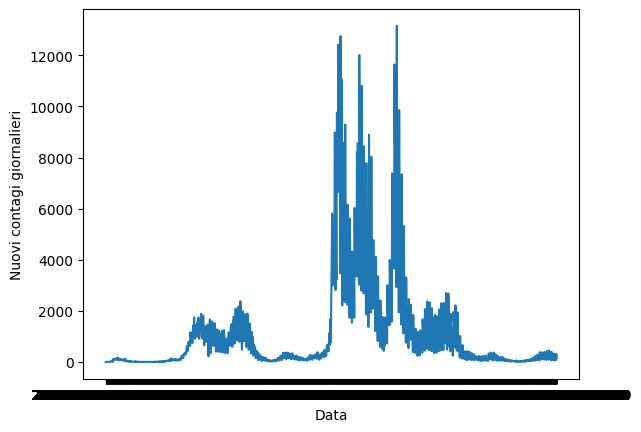

In [4]:
#GRAFICO INFINE L'ANDAMENTO DEI NUOVI CONTAGI GIORNALIERI PER LA REGIONE

plt.plot(data, n_positivi)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

**PARTE 2: IMPLEMENTAZIONE MODELLI EPIDEMIOLOGICI**

1) A questo punto possiamo procedere in primo luogo
implementando la funzione logistica e la funzione Gompertz, utili a descrivere la curva dei contagi.
In particolare, la forma della curva logistica, caratterizzata da una fase iniziale di rapida crescita seguita da una stabilizzazione, è coerente con molti andamenti epidemici osservati nella realtà. Mentre la funzione di Gompertz è particolarmente utile per modellare la fase di decrescita dei contagi, in cui il ritmo di diffusione del virus rallenta ma non si arresta improvvisamente. È quindi efficace nell'analizzare le fasi più avanzate di un'epidemia, dove la crescita non è più esponenziale ma segue un andamento più graduale.


In [5]:
def logistica(N_tot, k, t_0, t):
    return N_tot / (1 + np.exp(-k * (t - t_0)))

def gompertz(N_tot, k, t_0, t):
    exp1= np.exp( (-k)*(t-t_0))
    exp2= np.exp( (  (-1)*np.log(N_tot)) * exp1 )
    gomp= N_tot * exp2
    return gomp


In [6]:
#VERIFICO CHE LE FUNZIONI SIANO BEN DEFINITE E DIANO RISULTATI RAGIONEVOLI

1347
1572233
[1.00000000e+00 9.90049834e-01 9.80198673e-01 ... 1.45573446e-06
 1.44124966e-06 1.42690899e-06]
[   0    1    2 ... 1344 1345 1346] [ 786116.5         790047.04974547  793977.40297165 ... 1572230.71124957
 1572230.73402299 1572230.7565698 ]


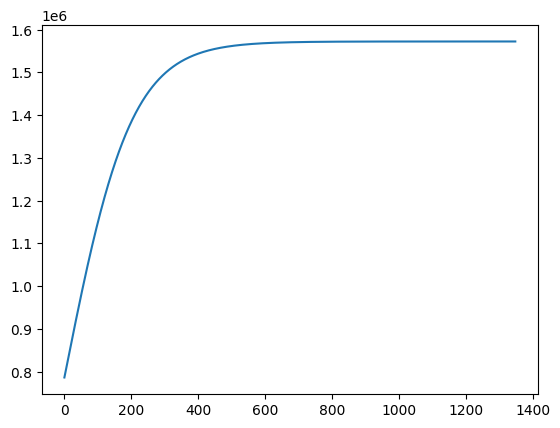

In [7]:
#LOGISTICA

# Dati osservati
t = np.arange(0, len(data),1)

Noss=n_positivi.to_numpy()

print(len(data))

#PARAMETRI INIZIALI ARBITRARI

N_tot = np.sum(Noss) # Totale dei contagi a fine ondata epidemica
k =0.01# Velocità di propagazione del contagio
t_0 = np.zeros(len(data))# Giorno di contagio del paziente 0

print(N_tot)

print(np.exp(-k*(t)))


L=logistica(N_tot, k, t_0, t)

print(t, L)

plt.plot(t, L)
plt.show()

1347
1572233
[1.00000000e+00 9.90049834e-01 9.80198673e-01 ... 1.45573446e-06
 1.44124966e-06 1.42690899e-06]
[   0    1    2 ... 1344 1345 1346] [1.00000000e+00 1.15254097e+00 1.32647557e+00 ... 1.57220034e+06
 1.57220067e+06 1.57220099e+06]


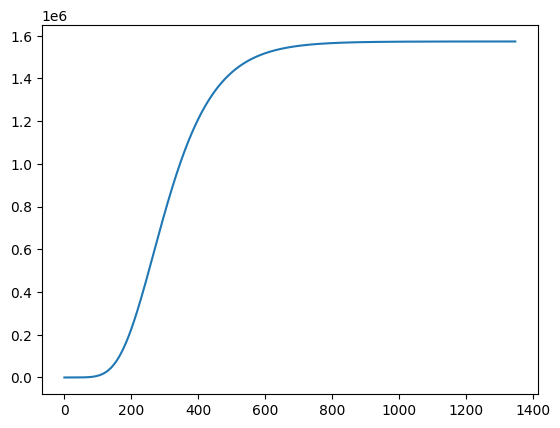

In [8]:
#GOMPERTZ

# Dati osservati
t = np.arange(0, len(data),1)

Noss=n_positivi.to_numpy()

print(len(data))

#PARAMETRI INIZIALI ARBITRARI

N_tot = np.sum(Noss) # Totale dei contagi a fine ondata epidemica
k =0.01 # Velocità di propagazione del contagio
t_0 = np.zeros(len(data))# Giorno di contagio del paziente 0

print(N_tot)

print(np.exp(-k*(t)))


G=gompertz(N_tot, k, t_0, t)

print(t, G)

plt.plot(t, G)
plt.show()


La funzione logistica() prende in input i parametri N_tot, k, e t_0 e restituisce il valore della funzione logistica al tempo t. La funzione gompertz() prende in input gli stessi parametri e restituisce il valore della funzione di Gompertz al tempo t.

Dove i parametri N_{tot}, k, e t_0 descrivono rispettivamente il totale dei contagi a fine ondata epidemica, la velocita’ di propagazione del contagio, e da quanto tempo l’epidemia e’ in corso (il giorno di contagio del paziente 0).

2) Quindi proseguiamo calcolando i contagi giornalieri predetti dai due modelli di funzione.


In [9]:
def nuovi_contagi_logistici(N_tot, k, t_0, t):
    return logistica(N_tot, k, t_0, t + 1) - logistica(N_tot, k, t_0, t)

def nuovi_contagi_gompertz(N_tot, k, t_0, t):
    return gompertz(N_tot, k, t_0, t+1) - gompertz(N_tot, k, t_0, t )

1347
1572233
[1.00000000e+00 9.90049834e-01 9.80198673e-01 ... 1.45573446e-06
 1.44124966e-06 1.42690899e-06]
[   0    1    2 ... 1344 1345 1346] [3.93054975e+03 3.93035323e+03 3.92996023e+03 ... 2.27734142e-02
 2.25468159e-02 2.23224720e-02]


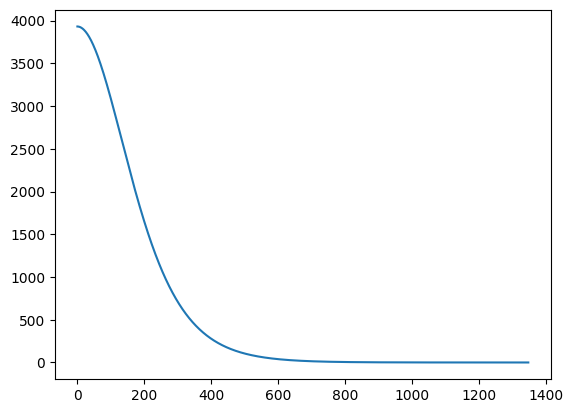

In [10]:
#VERIFICO IL GRAFICO DI QUESTI

#NUOVI CONTAGI LOGISTICA

# Dati osservati
t = np.arange(0, len(data),1)

Noss=n_positivi.to_numpy()

print(len(data))

#PARAMETRI INIZIALI ARBITRARI

N_tot = np.sum(Noss) # Totale dei contagi a fine ondata epidemica
k =0.01# Velocità di propagazione del contagio
t_0 = np.zeros(len(data))# Giorno di contagio del paziente 0

print(N_tot)

print(np.exp(-k*(t)))


L=nuovi_contagi_logistici(N_tot, k, t_0, t)

print(t, L)

plt.plot(t, L)
plt.show()

1347
1572233
[1.00000000e+00 9.90049834e-01 9.80198673e-01 ... 1.45573446e-06
 1.44124966e-06 1.42690899e-06]
[   0    1    2 ... 1344 1345 1346] [0.15254097 0.1739346  0.19805013 ... 0.32492547 0.32169248 0.31849165]


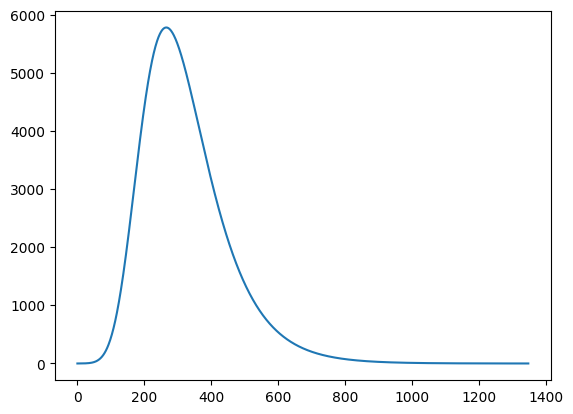

In [11]:
#NUOVI CONTAGI GOMPERTZ

# Dati osservati
t = np.arange(0, len(data),1)

Noss=n_positivi.to_numpy()

print(len(data))

#PARAMETRI INIZIALI ARBITRARI

N_tot = np.sum(Noss) # Totale dei contagi a fine ondata epidemica
k =0.01# Velocità di propagazione del contagio
t_0 = np.zeros(len(data))# Giorno di contagio del paziente 0

print(N_tot)

print(np.exp(-k*(t)))


G=nuovi_contagi_gompertz(N_tot, k, t_0, t)

print(t, G)

plt.plot(t, G)
plt.show()



La funzione nuovi_contagi_logistici() calcola la differenza tra i valori della funzione logistica al tempo t+1 e al tempo t. La funzione nuovi_contagi_gompertz() calcola la differenza tra i valori della funzione di Gompertz al tempo t+1 e al tempo t.



3) Sono a questo punto interessata a graficare l'andamento della funzioni predette al variare dei parametri e verificare se riescono ad emulare l'andamento dei dati. Si noti che i parametri verranno modificati manualmente in maniera arbitraria. Di seguito verrano riportate le combinazioni di parametri ritenute più significative.

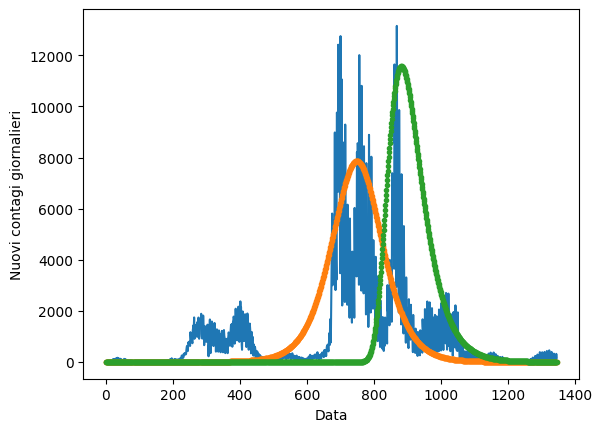

In [12]:
# Dati osservati
t = np.arange(0, len(data))  # con 35 giorni
Noss = n_positivi.to_numpy()

#PARAMETRI INIZIALI ARBITRARI

N_tot = np.sum(Noss) # Totale dei contagi a fine ondata epidemica
k = 0.02  # Velocità di propagazione del contagio
t_0 = 750 # Giorno di contagio del paziente 0


L=nuovi_contagi_logistici(N_tot, k, t_0, t)
G=nuovi_contagi_gompertz(N_tot, k, t_0, t)

plt.plot(t, n_positivi)
plt.plot(t[1:], L[1:], '.')
plt.plot(t[1:], G[1:], '.')
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

Quello che è stato verificato è che, tenendo fisso N_tot, come numero totali di contagi a fine pandemia e modificando gli altri parametri:


*   Variando t_0 viene traslata verso destra la posizione del picco
*   Aumentando k, il picco diventa più alto e con larghezza minore.



# **PARTE 3: ANALISI DELLA PRIMA ONDATA**

1) In primo luogo ci interesserà restringere l'analisi ai primi 35 giorni che seguono la comparsa dei primi casi di COVID 19 nella regione Puglia, fino al 30 Marzo 2020.

In [13]:
#RIDUCO L'AMPIEZZA DELLA SERIE DATA ALL'INTERVALLO TEMPORALE DI INTERESSE

# Definisci le date iniziali e finali
datain = "2020-03-29T17:00:00"
datafin = "2020-05-02T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
#datarid = data[(data >= datain) & (data <= datafin)]
datarid=data[data<=datain]

print(datarid)

#seleziono quindi unicamente i contagi corrispondenti

n_positivirid = n_positivi[datarid.index]

print(n_positivirid)

14     2020-02-24T18:00:00
35     2020-02-25T18:00:00
56     2020-02-26T18:00:00
77     2020-02-27T18:00:00
98     2020-02-28T18:00:00
119    2020-02-29T17:00:00
140    2020-03-01T17:00:00
161    2020-03-02T18:00:00
182    2020-03-03T18:00:00
203    2020-03-04T17:00:00
224    2020-03-05T17:00:00
245    2020-03-06T17:00:00
266    2020-03-07T18:00:00
287    2020-03-08T18:00:00
308    2020-03-09T18:00:00
329    2020-03-10T18:00:00
350    2020-03-11T17:00:00
371    2020-03-12T17:00:00
392    2020-03-13T17:00:00
413    2020-03-14T17:00:00
434    2020-03-15T17:00:00
455    2020-03-16T17:00:00
476    2020-03-17T17:00:00
497    2020-03-18T17:00:00
518    2020-03-19T17:00:00
539    2020-03-20T17:00:00
560    2020-03-21T17:00:00
581    2020-03-22T17:00:00
602    2020-03-23T17:00:00
623    2020-03-24T17:00:00
644    2020-03-25T17:00:00
665    2020-03-26T17:00:00
686    2020-03-27T17:00:00
707    2020-03-28T17:00:00
728    2020-03-29T17:00:00
Name: data, dtype: object
14       0
35       0
56     

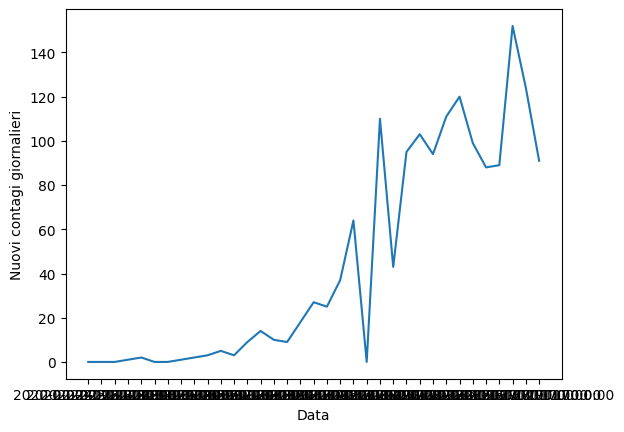

In [14]:
#Grafico l'andamento di questi giorni


plt.plot(datarid, n_positivirid)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


2) Supporrò ora che i nuovi contagi giornalieri seguano una funzione poissoniana con valore di aspettazione dato dalla funzione logistica e di Gompertz.


3) Procederò quindi al calcolo della funzione di Likelihood per la Poissoniana.

La likelihood poissoniana è data da:




\begin{equation}
 L(\lambda, k)=\prod_{i=1}^{n} \frac{e^{-{\lambda_i}}\lambda_i^{{k_i}}}{k_i!}\
\end{equation}


dove \begin{equation} \lambda_i \end{equation} è il valore atteso (predetto) dei contagi giornalieri sia per la funzione logistica che per la funzione di Gompertz. Esso viene calcolato mediante la funzione precedentemente introdotta denominata come "nuovi contagi", rispettivamente per la funzione logistica e per quella di Gompertz.
Mentre \begin{equation} {k_i} \end{equation}
è il numero effettivo di contagi giornalieri, ed n è il numero totale di giorni considerati.

**Algoritmo EMCEE**

Per cercare di descrivere l'andamento dei contagi sarà quindi necessario stimare i parametri che caratterizzano la funzione logistica e la funzione di Gompertz, quindi l'incertezza ad essi associata.
Una volta stimati questi parametri, sarà intuitivo calcolare usando le due differenti funzioni, il numero di nuovi contagi predetto giorno per giorno.

Per stimare il valore dei parametri e l'incertezza ad essi associata ci serviremo dell'algoritmo emcee:


1.   In prima battuta introdurremo, un prior distribution, una likelihood distribution quindi un posterior distribution. Il prior in particolare terrà conto del fatto che ci aspettiamo che Ntot sia al massimo il numero totale di contagi a fine dell'ondata, che t0 ovvero il tempo di inizio dei contagi dovrà essere minore di 35, in quanto stiamo valutando un'ondata durata 35 gironi ed infine ci aspettiamo che k sia indicativamente minore di 10.
2.   In secondo luogo, andremo a cercare la combinazione dei parametri che possa massimizzare la Likelihood, la quale diventerà luogo di partenza per i camminatori dell'emcee.
3. Passiamo quindi all'algortimo emcee vero e proprio: esso permette di esplorare in maniera efficace lo spazio dei parametri con un numero arbitrario di camminatori e quindi di catene di Markov parallele. Emcee può essere utilizzato per stimare i parametri di un modello statistico in base ai dati osservati, consentendo di trovare i valori dei parametri che massimizzano la verosimiglianza dei dati. Infatti l'idea è quella di ottenere, attraverso il metodo EMCEE un campione Monte Carlo che segua la Posterior Distribution, ovvero la distribuzione di probabilità dei parametri N_tot, k, t_o, che voglio stimare . Quindi dal campione estrarre  la miglior stima dei parametri e l'incertezza ad essi associata. Nel caso in questione è stata scelta come miglior stima la media del campione individuato, in questo essa tende al valore di aspettazione di una generica funzione di distribuzione quando il numero di elementi nel campione è elevato.
Per trovare invece l'incertezza ad essi associata è stato calcolato il 16esimo e l'84esimo percentile (ovvero il valore che corrisponde all'estrempo destro dell'intervallo all'interno del quale c'è il 16% e l'84% di probabilità, rispettivamente, che cadano gli eventi), cui è stata sotratta la stima dei parametri. Il motivo per cui sono stati scelti il 16° e l'84° percentile, risiede nel fatto che nel caso di una funzione di distribuzione gaussiana, il 16° percentile rappresenta il valore estremo che si ottiene sottraendo una deviazione standard al valore di aspettazione della gaussiana, mentre l'84° si ottiene aggiungendo una deviazione standard al valore di aspettazione.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[2.05719158e+03 2.34413440e-01 3.02262524e+01]


100%|██████████| 4000/4000 [00:19<00:00, 207.18it/s]


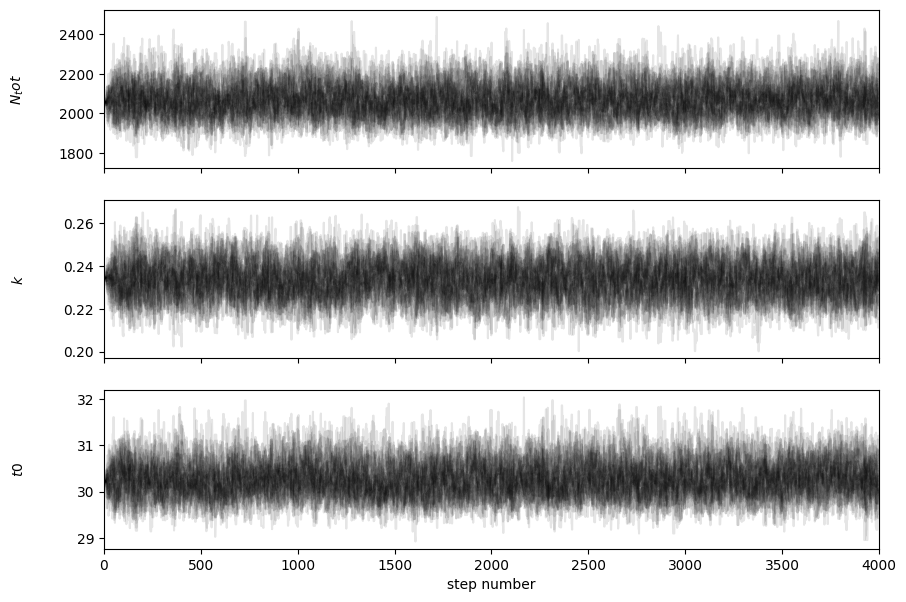

In [15]:
#FUNZIONE LOGISTICA

from scipy.special import gamma

# Calcolo della log-likelihood della distribuzione di Poisson

#--> probabilità di ottenere i dati se fissati certi parametri e un dato modello.
def log_likelihood(params, t, osservati): #logostica poisson likelihood
    Ntot, k, t_0 = params
    predetti= nuovi_contagi_logistici(Ntot, k, t_0, t)
    log_likelihood = np.sum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    #la funzione gamma serve per il fattoriale
    return log_likelihood


# Definizione del logaritmo del prior piatto

#--> probabilità dei parametri del modello.
def log_prior(params):
    Ntot, k, t_0 = params
    if 0 < Ntot < 3500 and 0 < k < 10 and 0 < t_0 < 35:
      #SI NOTI CHE IL LIMITE SUPERIORE DI NTOT E' MAGGIORE RISPETTO AL NUMERO DI CONATGI TOTALE FINO AL 30.03.2020
      #IL MOTIVO DIETRO QUESTA SCELTA VERRA' DISCUSSO IN SEGUITO NEL COMMENTO E ANALISI DEI RISULTATI
        return 0
    return -np.inf

#--> probabilità dei parametri una volta scelto il modello e raccolti i dati.

# Definizione del logaritmo del posterior
def log_posterior(params, t, osservati):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati
t = np.arange(0, 35,1)  # con 35 giorni
Nosservati = n_positivirid.to_numpy()


#PARAMETRI INIZIALI ARBITRARI

Ntotini = np.sum(Nosservati) # Totale dei contagi a fine ondata epidemica
kini = 1.6 # Velocità di propagazione del contagio
t0ini = 20  # Giorno di contagio del paziente 0


# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0


# Definisco la funzione da minimizzare, ovvero la logPosterior cambiata di segno poichè voglio in realtà massimizzarla
nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
LNtot_estimated, Lk_estimated, Lt0_estimated = result.x

#result.x è un vettore che contiene i valori dei parametri che minimizzano la funzione obiettivo.


print(result.x)

ndim=3 #numero parametri modello
nwalkers=32

# Perturbo i parametri iniziali e inizializzo i walkers che vanno ad esplorare lo spazio dei parametri
# è infatti ragionevole iniziare a esplorare lo spazio dei parametri a partire dalla combinazione di parametri che massimizzazione la Likelihood
# ovvero minimizzano la -logposterior

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t,Nosservati))
sampler.run_mcmc(pos, 4000, progress=True);



fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");




# Calcolo dei valori stimati dei parametri e delle incertezze
Lestimated_params = np.mean(samples, axis=(0,1))
Lparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Lestimated_params






Nei plot sopra riportati, vengono mostrati per ogni step delle catene di Markov, la posizione assunta dai camminatori nello spazio dei parametri. Da questo plot osserviamo che le catene oscillano tutte attorno ad un certo valore che sarà il valore più probabile del parametro (in corrispondenza di esso troveremo il picco della Posterior distribution), senza occupare tutto lo spazio dei parametri.

In [16]:
print(Lestimated_params)
print(Lparam_uncertainties)

[2.06920838e+03 2.33617641e-01 3.02779821e+01]
[[-8.00567287e+01 -8.55466263e-03 -3.75770891e-01]
 [ 7.96998282e+01  8.51015776e-03  3.72719534e-01]]


Procedo in maniera analoga a quanto fatto sopra usando la funzione di Gompertz, alla fine di questo procedimento verificheremo la compatibilità tra la distribuzione ottenuta e i dati veri e propri.

<ipython-input-17-283f362e29ea>:9: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
<ipython-input-17-283f362e29ea>:9: RuntimeWarning: invalid value encountered in multiply
  log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [00:09<00:00, 419.27it/s]


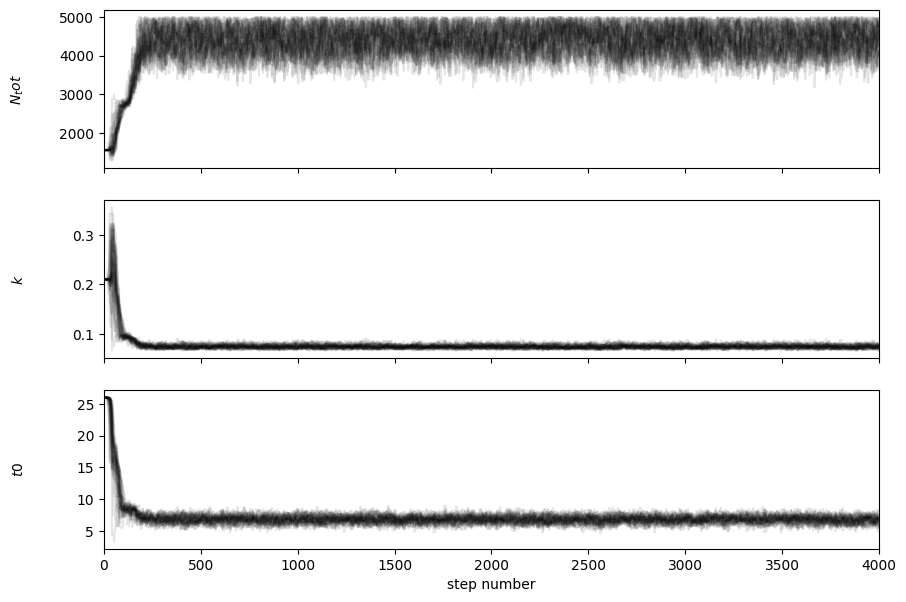

In [17]:
#FUNZIONE GOMPERTZ



# Calcolo della log-likelihood della distribuzione di Poisson
def log_likelihood(params, t, osservati): #logostica poisson likelihood
    Ntot, k, t_0 = params
    predetti= nuovi_contagi_gompertz(Ntot, k, t_0, t)
    log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood


# Definizione del logaritmo del prior piatto
def Glog_prior(params):
    Ntot, k, t_0 = params
    if 0 < Ntot < 5000 and 0 < k < 5 and 0 < t_0 < 35:
        return 0
    return -np.inf

# Definizione del logaritmo del posterior
def log_posterior(params, t, osservati):
    Ntot, k, t_0 = params
    lp = Glog_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati
t = np.arange(0, 35,1)  # con 35 giorni
Nosservati = n_positivirid.to_numpy()


#PARAMETRI INIZIALI ARBITRARI

Ntotini = np.sum(Nosservati)# Totale dei contagi a fine ondata epidemica
kini = 0.21# Velocità di propagazione del contagio
t0ini = 26 # Giorno di contagio del paziente 0

# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0

nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
GNtot_estimated, Gk_estimated, Gt0_estimated = result.x

#Inizializzazione di emcee
ndim=3 #numero parametri modello
nwalkers=32 #numero di catene di Markov

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t,Nosservati)
)
sampler.run_mcmc(pos, 4000, progress=True);



fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


# Calcolo dei valori stimati dei parametri e delle incertezze
Gestimated_params = np.mean(samples, axis=(0,1))
Gparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Gestimated_params





In questo caso già dopo poche iterazioni i camminatori si muovo dal valore iniziale dei parametri, per raggiungere quello più probabile e oscillare in prossimità di questo.

In [18]:
print(Gestimated_params)
print(Gparam_uncertainties)

[4.31809907e+03 7.71545328e-02 7.10922198e+00]
[[-3.35577645e+02 -6.45975097e-03 -8.56191850e-01]
 [ 4.47704322e+02  1.14157443e-03  3.33353676e-01]]


4a) Procedo infine graficando le distribuzione ottenute in relazione ai dati veri e propri.

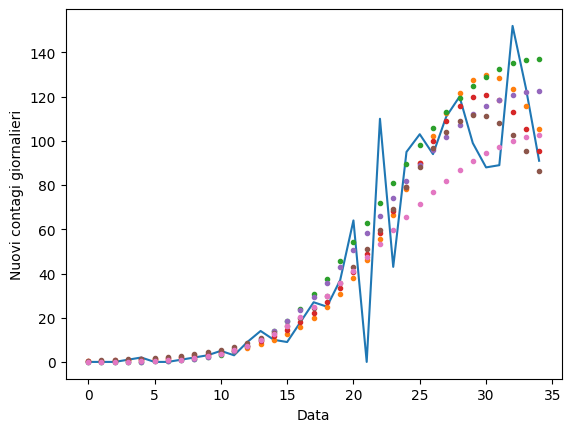

In [19]:
t = np.arange(0, 35,1)  # con 35 giorni


#SOPRA
SLN_tot=Lestimated_params[0]+Lparam_uncertainties[1,0]
SLk=Lestimated_params[1]+Lparam_uncertainties[1,1]
SLt0=Lestimated_params[2]+Lparam_uncertainties[1,2]

SGN_tot=Gestimated_params[0]+Gparam_uncertainties[1,0]
SGk=Gestimated_params[1]+Gparam_uncertainties[1,1]
SGt0=Gestimated_params[2]+Gparam_uncertainties[1,2]

SLy=nuovi_contagi_logistici(SLN_tot, SLk, SLt0, t)
SGy=nuovi_contagi_gompertz(SGN_tot, SGk, SGt0, t)



#CENTRO


LN_tot=Lestimated_params[0]
Lk=Lestimated_params[1]
Lt0=Lestimated_params[2]

GN_tot=Gestimated_params[0]
Gk=Gestimated_params[1]
Gt0=Gestimated_params[2]

Ly=nuovi_contagi_logistici(LN_tot, Lk, Lt0, t)
Gy=nuovi_contagi_gompertz(GN_tot, Gk, Gt0, t)



#SOTTO (GIU')

GLN_tot=Lestimated_params[0]+Lparam_uncertainties[0,0]
GLk=Lestimated_params[1]+Lparam_uncertainties[0,1]
GLt0=Lestimated_params[2]+Lparam_uncertainties[0,2]

GGN_tot=Gestimated_params[0]+Gparam_uncertainties[0,0]
GGk=Gestimated_params[1]+Gparam_uncertainties[0,1]
GGt0=Gestimated_params[2]+Gparam_uncertainties[0,2]

GLy=nuovi_contagi_logistici(GLN_tot, GLk, GLt0, t)
GGy=nuovi_contagi_gompertz(GGN_tot, GGk, GGt0, t)


#print(np.random.poisson(Ly))

plt.plot(t, n_positivirid)

#SOPRA
plt.plot(t, (SLy), '.')
plt.plot(t, (SGy), '.')


#CENTRO
plt.plot(t, (Ly), '.')
plt.plot(t, (Gy), '.')


#SOTTO
plt.plot(t, (GLy), '.')
plt.plot(t, (GGy), '.')

plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

Abbiamo graficato anche l'andamento delle curve che si ottengono considerando i parametri ottenuti, più o meno una deviazione standard ad essi associati. In questo modo abbaimo individuato l'intervallo di incertezza teorica associato al modello, dovuto all'incertezza che caratterizza i parametri stessi.

4b) Sono quindi interessata ad analizzare come la predizione fatta dopo i primi 35 giorni possa corrispondere all'andamento osservato nei primi 100 giorni (sia giornaliero sia cumulativo).

*Andamento giornaliero:*

In [20]:
from datetime import datetime, timedelta

# Data di partenza
data_partenza = datetime(2020, 2, 24)

# Aggiungi 100 giorni
data_arrivo = data_partenza + timedelta(days=100)

print(data_arrivo)

2020-06-03 00:00:00


In [21]:
#RIDUCO L'AMPIEZZA DELLA SERIE DATA ALL'INTERVALLO TEMPORALE DI 100 GIORNI

data_arrivo="2020-06-03T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
#datarid = data[(data >= datain) & (data <= datafin)]
data100=data[data<data_arrivo]

print(data100)

#seleziono quindi unicamente i contagi corrispondenti

n_positivi100 = n_positivi[data100.index]

#print(n_positivi100)
print(len(n_positivi100))

14      2020-02-24T18:00:00
35      2020-02-25T18:00:00
56      2020-02-26T18:00:00
77      2020-02-27T18:00:00
98      2020-02-28T18:00:00
               ...         
2009    2020-05-29T17:00:00
2030    2020-05-30T17:00:00
2051    2020-05-31T17:00:00
2072    2020-06-01T17:00:00
2093    2020-06-02T17:00:00
Name: data, Length: 100, dtype: object
100


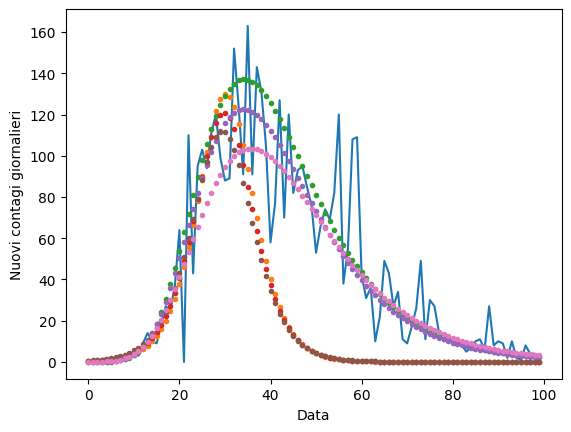

In [22]:
#GRAFICO L'ANDAMENTO GIORNALIERO


t = np.arange(0, 100,1)  # con 100 giorni


#SOPRA
SLN_tot=Lestimated_params[0]+Lparam_uncertainties[1,0]
SLk=Lestimated_params[1]+Lparam_uncertainties[1,1]
SLt0=Lestimated_params[2]+Lparam_uncertainties[1,2]

SGN_tot=Gestimated_params[0]+Gparam_uncertainties[1,0]
SGk=Gestimated_params[1]+Gparam_uncertainties[1,1]
SGt0=Gestimated_params[2]+Gparam_uncertainties[1,2]

SLy=nuovi_contagi_logistici(SLN_tot, SLk, SLt0, t)
SGy=nuovi_contagi_gompertz(SGN_tot, SGk, SGt0, t)



#CENTRO


LN_tot=Lestimated_params[0]
Lk=Lestimated_params[1]
Lt0=Lestimated_params[2]

GN_tot=Gestimated_params[0]
Gk=Gestimated_params[1]
Gt0=Gestimated_params[2]

Ly=nuovi_contagi_logistici(LN_tot, Lk, Lt0, t)
Gy=nuovi_contagi_gompertz(GN_tot, Gk, Gt0, t)



#SOTTO (GIU')

GLN_tot=Lestimated_params[0]+Lparam_uncertainties[0,0]
GLk=Lestimated_params[1]+Lparam_uncertainties[0,1]
GLt0=Lestimated_params[2]+Lparam_uncertainties[0,2]

GGN_tot=Gestimated_params[0]+Gparam_uncertainties[0,0]
GGk=Gestimated_params[1]+Gparam_uncertainties[0,1]
GGt0=Gestimated_params[2]+Gparam_uncertainties[0,2]

GLy=nuovi_contagi_logistici(GLN_tot, GLk, GLt0, t)
GGy=nuovi_contagi_gompertz(GGN_tot, GGk, GGt0, t)


plt.plot(t, n_positivi100)

#SOPRA
plt.plot(t, (SLy), '.')
plt.plot(t, (SGy), '.')


#CENTRO
plt.plot(t, (Ly), '.')
plt.plot(t, (Gy), '.')


#SOTTO
plt.plot(t, (GLy), '.')
plt.plot(t, (GGy), '.')

plt.xlabel('Data')
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


*Andamento cumulativo:*

Procederò a questo punto analizzando il numero di contagi totali giorno dopo giorno e non il numero di nuovi contagi.

In [23]:
array=[0,1,2,3,4,5]

somma=np.cumsum(array)

print(somma)

[ 0  1  3  6 10 15]


In [24]:
positivi100=n_positivi100.to_numpy()

sommepositivi100=np.cumsum(positivi100)

sommepositivi35=np.cumsum(Nosservati)

I parametri ottenuti nella sezione precedente mediante l'algoritmo emcee, sono gli stessi sia per la funzione che calcola i nuovi contagi a partire dalla logistica (o da Gompertz), che per la funzione logistica (o Gompertz) vera e propria. Segue quindi che i parametri precedenetmente ottenuti sono stati considerati attendibili e quindi sono stati impiegati nella realizzazione del grafico della funzione logitisca e di Gompertz.

Graficherò adesso l'andamento cumulativo dopo 100 giorni:

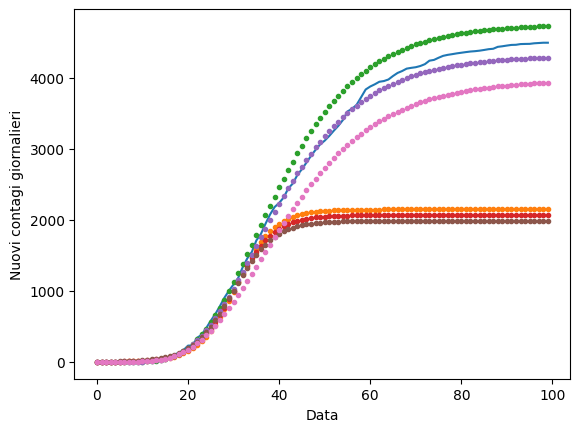

In [25]:
t = np.arange(0, 100,1)  # con 100 giorni


#SOPRA
SLN_tot=Lestimated_params[0]+Lparam_uncertainties[1,0]
SLk=Lestimated_params[1]+Lparam_uncertainties[1,1]
SLt0=Lestimated_params[2]+Lparam_uncertainties[1,2]

SGN_tot=Gestimated_params[0]+Gparam_uncertainties[1,0]
SGk=Gestimated_params[1]+Gparam_uncertainties[1,1]
SGt0=Gestimated_params[2]+Gparam_uncertainties[1,2]

SLy=logistica(SLN_tot, SLk, SLt0, t)
SGy=gompertz(SGN_tot, SGk, SGt0, t)



#CENTRO


LN_tot=Lestimated_params[0]
Lk=Lestimated_params[1]
Lt0=Lestimated_params[2]

GN_tot=Gestimated_params[0]
Gk=Gestimated_params[1]
Gt0=Gestimated_params[2]

Ly=logistica(LN_tot, Lk, Lt0, t)
Gy=gompertz(GN_tot, Gk, Gt0, t)



#SOTTO (GIU')

GLN_tot=Lestimated_params[0]+Lparam_uncertainties[0,0]
GLk=Lestimated_params[1]+Lparam_uncertainties[0,1]
GLt0=Lestimated_params[2]+Lparam_uncertainties[0,2]

GGN_tot=Gestimated_params[0]+Gparam_uncertainties[0,0]
GGk=Gestimated_params[1]+Gparam_uncertainties[0,1]
GGt0=Gestimated_params[2]+Gparam_uncertainties[0,2]

GLy=logistica(GLN_tot, GLk, GLt0, t)
GGy=gompertz(GGN_tot, GGk, GGt0, t)


plt.plot(t, sommepositivi100)

#SOPRA
plt.plot(t, (SLy), '.')
plt.plot(t, (SGy), '.')


#CENTRO
plt.plot(t, (Ly), '.')
plt.plot(t, (Gy), '.')


#SOTTO
plt.plot(t, (GLy), '.')
plt.plot(t, (GGy), '.')


plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

Mentre la funzione logistica segue l'andamento dei dati in prossimità del picco e quindi si attesta ad valore stazionario pari a 2000 appunto in prossimità del picco stesso, la funzione di Gompertz riesce a riprodurre bene l'andamento cumulativo dei contagi, come ci si aspetta, anche superata la prima ondata e nel periodo successivo al picco di nuovi contagi giornaliero

***Commenti relativi a quanto ottenuto:***

In un primo momento, durante la realizzazione dell'algoritmo emcee, nella funzione di Prior è stato introdotto un limite massimo al parametro N_tot e tale limite coincideva con il numero totae di contagi dopo 35 giorni.

Mantenendo un prior con quel limite imposto dall'alto, i parametri ricavati permettevano di ottenere una curva che descrivesse più o mneno bene l'andamento dei contagi nei primi 35 giorni ma non si adattasse quasi per nulla ai dati raccolti nei primi 100 giorni.

Questo era particolarmente vero per la funzione di Gompertz, come ci si potrebbe aspettare, in quanto essa è pensata al fine di descrivere nella maniera più verosimile la fase di descrescita dei contagi, quindi appunto la fase che segue i primi 35 giorni.

Per oviare a questo problema, si è scelto dunque un prior che non fosse così stringente nella scelta dei parametri e che la lasciasse abbastanza spazio nell'individuazione di N_tot per la funzione di Gompertz.

I parametri ottenuti in questo secondo momento hanno permesso di ricavare due curve tali che:


*   La prima, relativa alla funzione logistica, descrive l'andamento del picco dei contagi, situato in prossimità dei 35 giorni
*   La seconda, invece, relativa alla funzione di Gompertz, descrive la decrescita dei contagi che segue il picco, a partire dai 40 fino alla fine dei 100 giorni.



# **PARTE 4: MODELIZZAZIONE DELL'INTERVALLO 03.06.2020-03.06.2021**

In primo luogo procedere graficando l'andamento dei contagi giornalieri in questo secondo intervallo di tempo, per poi commentare le possibili modlaità di modelizzazione della distrbuzione dei contagi.

In [26]:
#RIDUCO L'AMPIEZZA DELLA SERIE DATA ALL'INTERVALLO TEMPORALE DI INTERESSE

# Definisci le date iniziali e finali
datain = "2020-06-23T17:00:00"
datafin = "2021-06-03T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
datagiugno = data[(data >= datain) & (data <= datafin)]
#datarid=data[data<=datain]

print(datagiugno)

#seleziono quindi unicamente i contagi corrispondenti

n_positivigiugno = n_positivi[datagiugno.index]

print(n_positivigiugno)
print(len(datagiugno))



2534    2020-06-23T17:00:00
2555    2020-06-24T17:00:00
2576    2020-06-25T17:00:00
2597    2020-06-26T17:00:00
2618    2020-06-27T17:00:00
               ...         
9695    2021-05-30T17:00:00
9716    2021-05-31T17:00:00
9737    2021-06-01T17:00:00
9758    2021-06-02T17:00:00
9779    2021-06-03T17:00:00
Name: data, Length: 346, dtype: object
2534      2
2555      0
2576      1
2597      1
2618      0
       ... 
9695     90
9716    142
9737    227
9758    196
9779     44
Name: nuovi_positivi, Length: 346, dtype: int64
346


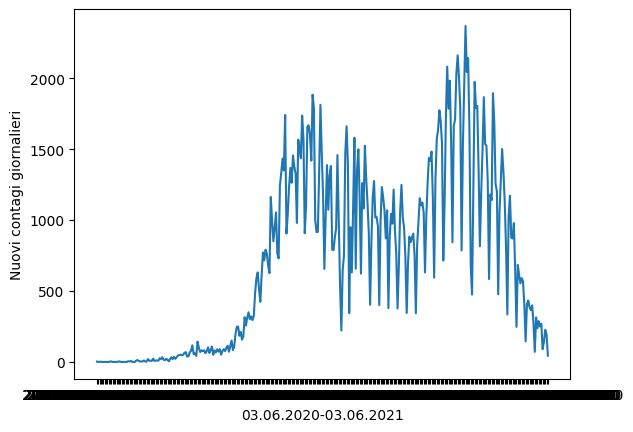

In [27]:
plt.plot(datagiugno, n_positivigiugno)
plt.xlabel("03.06.2020-03.06.2021")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

Dal grafico sopra emerge che, a differenza di prima, durante questo nuovo intervallo di tempo si sono conseguiti due picchi. Per riprodurre quindi l'andamento dei dati in questo caso, risulta più conviente lavorare con due funzioni leggermente differenti: esse saranno a loro volta somma rispettivamente di due funzioni logistiche e di due funzioni di Gompertz, dove ognuna di loro dipende da 3 parametri indipendenti e differenti dalle altre. In questo modo sarà possibile riprodurre l'andamento di ognuno dei due picchi.
Tali funzioni sono state per chiarezza definite sotto.

Si verifica che ognuna di queste dipende da 6 parametri, ragione per cui nel momento in cui si andrà ad implementare l'algoritmo emcee, l'interesse sarà volto non più alla stima di soli 3 parametri, ma alla stima di 6.


Alternativamente, per facilitare la stima dei parametri potrebbe essere conveniente in prima battuta studiare l'intervallo temporale contente solo il primo picco, cercare di descrivere l'andamento dei dati con una funzione logistica e una di Gompertz, quindi individuare i 3 rispettivi parametri con l'algoritmo emcee. In secondo luogo l'operazione verrebbe ripetuta considerando solo l'intervallo temporale che contiene unicamente il secondo picco, quindi solo infine si potrebbe passare al grafico complessivo e rappresentare le funzioni dipendenti dai 6 parametri che saranno già stati precedentemente determinati.

In [28]:
#INTRODUCO LE NUOVE FUNZIONI

#LOGISTICA CON DUE PICCHI

def duelogistica(N1_tot, k1, t_01, N2_tot, k2, t_02, t):
    term1= N1_tot / (1 + np.exp(-k1 * (t - t_01)))
    term2= N2_tot / (1 + np.exp(-k2 * (t - t_02)))
    return term1+term2



#GOMPERTZ CON DUE PICCHI


def duegompertz(N1_tot, k1, t_01, N2_tot, k2, t_02, t):
    exp11= np.exp( (-k1)*(t-t_01))
    exp21= np.exp( (  (-1)*np.log(N1_tot)) * exp11 )
    gomp1= N1_tot * exp21
    exp21= np.exp( (-k2)*(t-t_02))
    exp22= np.exp( (  (-1)*np.log(N2_tot)) * exp21 )
    gomp2= N2_tot * exp22
    return gomp1+gomp2

#NUOVI CONTAGI

def duenuovi_contagi_logistici(N1_tot, k1, t_01,N2_tot, k2, t_02, t):
    return duelogistica(N1_tot, k1, t_01,N2_tot, k2, t_02, t+1) - duelogistica(N1_tot, k1, t_01,N2_tot, k2, t_02, t)

def duenuovi_contagi_gompertz(N1_tot, k1, t_01,N2_tot, k2, t_02, t):
    return duegompertz(N1_tot, k1, t_01,N2_tot, k2, t_02, t+1) - duegompertz(N1_tot, k1, t_01,N2_tot, k2, t_02, t )

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

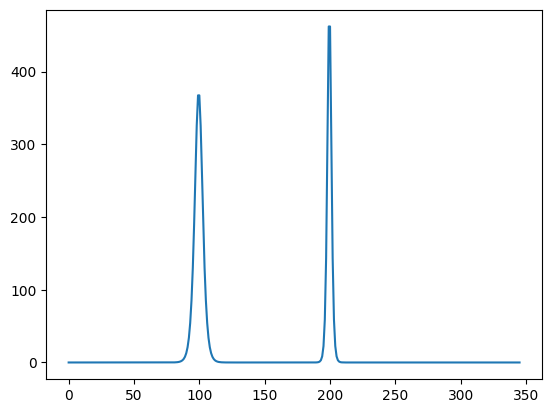

In [29]:
#VERIFICO IL GRAFICO DI QUESTI

#NUOVI CONTAGI LOGISTICA

# Dati osservati
t = np.arange(0, 346,1)

Noss=n_positivigiugno.to_numpy()

N1totini = 3000# Totale dei contagi a fine ondata epidemica
k1ini = 0.5 # Velocità di propagazione del contagio
t01ini = 100  # Giorno di contagio del paziente 0


N2totini = 2000# Totale dei contagi a fine ondata epidemica
k2ini = 1 # Velocità di propagazione del contagio
t02ini = 200  # Giorno di contagio del paziente 0


L=duenuovi_contagi_logistici(N1totini, k1ini, t01ini, N2totini, k2ini, t02ini,t)

print(t, L)

plt.plot(t, L)
plt.show()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

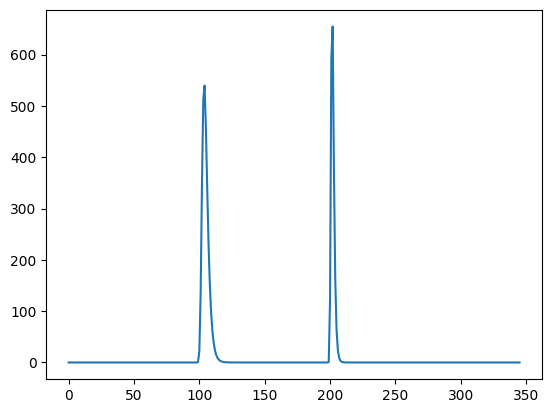

In [30]:
#VERIFICO IL GRAFICO DI QUESTI

#NUOVI CONTAGI LOGISTICA

# Dati osservati
t = np.arange(0, 346,1)

Noss=n_positivigiugno.to_numpy()

N1totini = 3000# Totale dei contagi a fine ondata epidemica
k1ini = 0.5 # Velocità di propagazione del contagio
t01ini = 100  # Giorno di contagio del paziente 0


N2totini = 2000# Totale dei contagi a fine ondata epidemica
k2ini = 1 # Velocità di propagazione del contagio
t02ini = 200  # Giorno di contagio del paziente 0


G=duenuovi_contagi_gompertz(N1totini, k1ini, t01ini, N2totini, k2ini, t02ini,t)

print(t, G)

plt.plot(t, G)
plt.show()